In [5]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, "python")

import matplotlib.pyplot as plt
import numdifftools as nd
import pandas as pd
import respy as rp
import numpy as np

from calibration_maximum_likelihood import get_bootstrap_sample
from calibration_maximum_likelihood import run_bootstrap
from estimagic.optimization.optimize import maximize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Maximum likelihood estimation

In [6]:
params_base, options_base, df = rp.get_example_model("robinson", with_data=True)

## Likelihood function

We can now start exploring the likelihood function. We will first trace out the profile likelihood over reasonable parameter values.

In [7]:
params_base["lower"] = [0.91, 0.065, -0.20, 1.00, 0.0030, 0.001, -0.99]
params_base["upper"] = [0.99, 0.075,  0.00, 1.10, 0.1000, 0.030, +0.99]

# We will use estimagic and fix all parameters at their true values.
constr_base = [
    {"loc": ("shocks_sdcorr", "sd_fishing"), "type": "fixed"}, 
    {"loc": ("shocks_sdcorr", "sd_hammock"), "type": "fixed"}, 
    {"loc": ("shocks_sdcorr", "corr_hammock_fishing"), "type": "fixed"}, 
    {"loc": "wage_fishing", "type": "fixed"},
    {"loc": "nonpec_fishing", "type": "fixed"},
    {"loc": "nonpec_hammock", "type": "fixed"}
]

### Profile likelihood

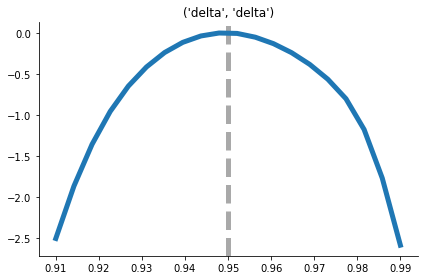

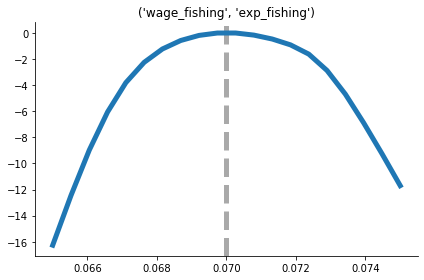

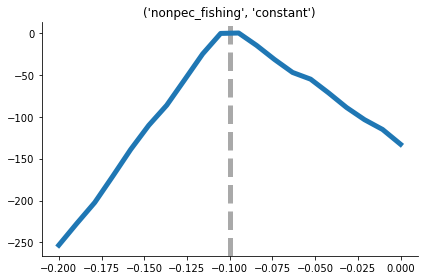

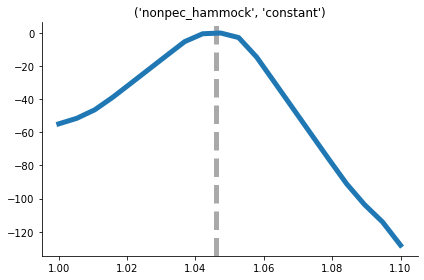

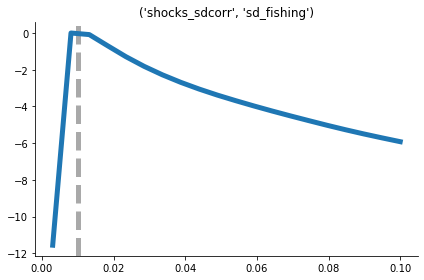

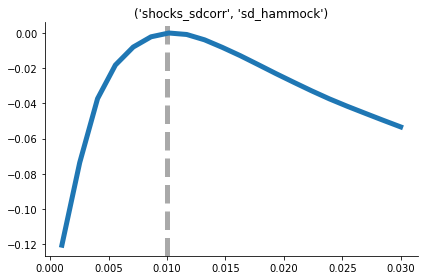

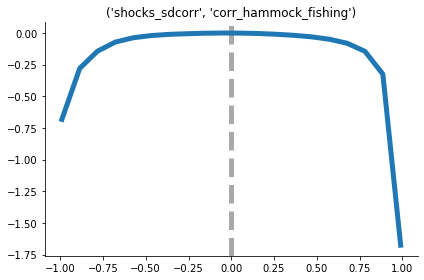

In [188]:
crit_func = rp.get_crit_func(params_base, options_base, df)

for index in params_base.index:
    upper, lower = params_base.loc[index][["upper", "lower"]]

    grid = np.linspace(lower, upper, 20)
    
    fvals = list()
    for value in grid:
        params = params_base.copy()
        params.loc[index, "value"] = value
        fvals.append(crit_func(params))
    
    fig, ax = plt.subplots()

    ax.axvline(params_base.loc[index, "value"], color="#A9A9A9", linestyle="--", label="Baseline")
    
    fvals_normalized = np.array(fvals) - np.max(fvals)
    
    ax.plot(grid, fvals_normalized)
    ax.set_title(index)
    plt.show()

Going forward, we will focus on the discount factor $\delta$ and treat it as the only unknown parameter.

In [199]:
crit_func = rp.get_crit_func(params_base, options_base, df)
results, params_rslt = maximize(
                    crit_func, params_base, 
                    "nlopt_bobyqa", 
                    algo_options={"maxeval": 100}, 
                    constraints=constr_base, 
        )
mle_delta = params_rslt.loc[("delta", "delta"), "value"]





/home/peisenha/external_storage/ownCloud/office/OpenSourceEconomics/respy/respy/likelihood.py:296: RuntimeWarning: divide by zero encountered in simulate_log_probability_of_individuals_observed_choice
  options["estimation_tau"],


In [207]:
def wrapper_crit_func(crit_func, params_base, index, values):
    if isinstance(values, float):
        values = [values]

    params = params_base.copy()

    fvals = list()
    for value in values:
        params.loc[index, "value"] = value
        fvals.append(crit_func(params))

    if len(fvals) == 1:
        fvals = fvals[0]

    return fvals

index = ("delta", "delta")
p_wrapper_crit_func = partial(wrapper_crit_func, crit_func, params_base, index)

fisher_delta = -nd.Derivative(p_wrapper_crit_func, n=2)([mle_est]) 

/home/peisenha/external_storage/ownCloud/office/OpenSourceEconomics/respy/respy/likelihood.py:296: RuntimeWarning: divide by zero encountered in simulate_log_probability_of_individuals_observed_choice
  options["estimation_tau"],


In [208]:
fisher_delta

2200.401123933846

## Score statistic

### Distribution

The asymptotic normality of the score statistic is of key importance in deriving the asymptotic normality of the maximum likelihood estimator. Here we simulate $100$ samples of $10,000$ individuals and compute the score function at the true values. I had to increase the number of simulated individuals as convergence to the asymptotic distribution just took way to long.

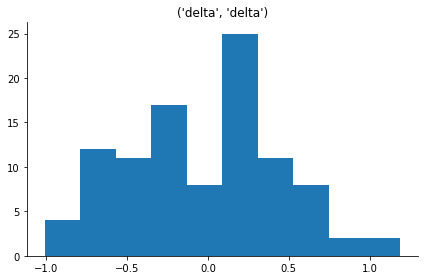

In [248]:
index = ("delta", "delta")
rslts = pkl.load(open(f"score.{index[0]}.pkl", "rb"))
    
fig, ax = plt.subplots()
    
ax.hist(rslts)
ax.set_title(f"{index}")

plt.show()

### Linearity

We need linearity of the score function around the true value so that the log-likelihood is reasonably well approximated by a second order Taylor-polynomial.

In [253]:
NUM_SIMULATIONS = 10000
index = ("delta", "delta")


index = ("delta", "delta")
p_wrapper_crit_func = partial(wrapper_crit_func, crit_func, params_base, index)

fisher_delta = -nd.Derivative(p_wrapper_crit_func, n=2)([mle_est]) 

options = options_base.copy()
options["simulation_seed"] = iter_
options["simulation_agents"] = NUM_SIMULATIONS

simulate = rp.get_simulate_func(params_base, options)
df = simulate(params_base)

crit_func = rp.get_crit_func(params_base, options, df)
p_wrapper_crit_func = partial(wrapper_crit_func, crit_func, params_base, index)

upper, lower = params_base.loc[index, ["upper", "lower"]]

num_points = 10
grid = np.linspace(lower, upper, num_points)

fds = np.tile(np.nan, num_points)
for i, point in enumerate(grid):
    fds[i] = approx_fprime([point], p_wrapper_crit_func, 10e-6)

/home/peisenha/external_storage/ownCloud/office/OpenSourceEconomics/respy/respy/likelihood.py:296: RuntimeWarning: divide by zero encountered in simulate_log_probability_of_individuals_observed_choice
  options["estimation_tau"],


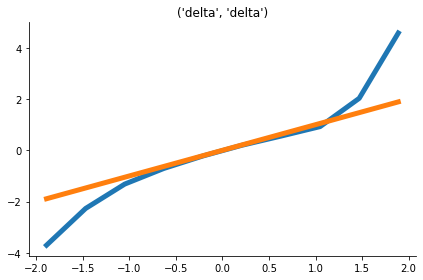

In [254]:
norm_fds = fds * - (1 / np.sqrt(fisher_delta))
norm_grid = (grid - 0.95) *   (np.sqrt(fisher_delta))
fig, ax = plt.subplots()
    
ax.set_title(f"{index}")

ax.plot(norm_grid, norm_fds)
ax.plot(norm_grid, norm_grid)


plt.show()

In [257]:
norm_grid

array([-1.88898582, -1.4692112 , -1.04943657, -0.62966194, -0.20988731,
        0.20988731,  0.62966194,  1.04943657,  1.4692112 ,  1.88898582])

## Bootstrap

We can now run a simple bootstrap to see how the asymptotic standard errors line up.

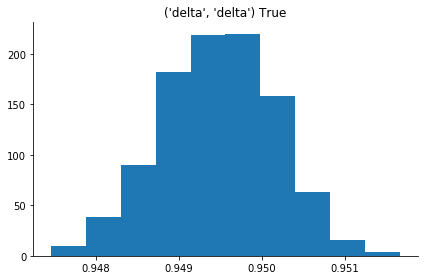

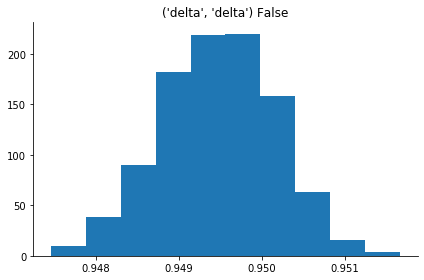

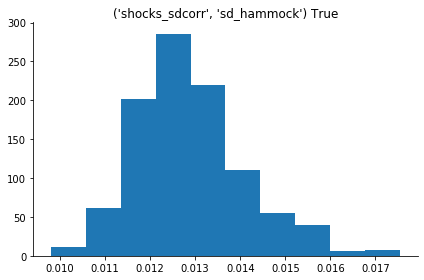

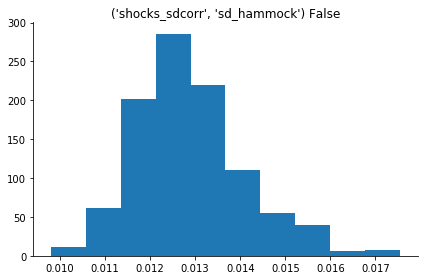

In [174]:
for i, index in enumerate([("delta", "delta"), ("shocks_sdcorr", "sd_hammock")]):
    
    for is_perturb in [True, False]:

        fname = f"bootstrap.{index[1]}_perturb_{str(is_perturb).lower()}.pkl"
        boot_params = pd.read_pickle(fname)

        fig, ax = plt.subplots()

        ax.hist(boot_params.loc[index, :])
        ax.set_title(f"{index} {is_perturb}")

        plt.show()

## Likelihood-based intervals

In [9]:
from scipy.optimize import root_scalar

# I just take the first ones, even thought these are not the estimates


def find_root(delta, index):
    
    params_eval = params_base.copy()
    params_eval.loc[index] = delta

    likl_ratio = np.exp(crit_func(params_eval)- crit_func(params_base))    
    
    return likl_ratio
    
def root_wrapper(delta, alpha, index):
    
    assert alpha in [0.05, 0.001]
    
    if alpha == 0.05:
        crit_val = 0.15
    else:
        crit_val = 0.04
    
    return find_root(delta, index) - crit_val

In [10]:
specs = dict()

specs["delta"] = dict()
specs["delta"]["bracket"] = [[0.75, 0.95], [0.95, 1.10]]

for i, index in enumerate([("delta", "delta")]):
    rslt = list()
    for bracket in specs[index[1]]["bracket"]:
        root = root_scalar(root_wrapper, method="bisect", bracket=bracket, args=(0.05, index)).root
        rslt.append(root)
    print("{:5.3f} / {:5.3f}".format(*rslt))

0.915 / 0.986


## Large-sample approximation

In [11]:
fdd = nd.Derivative(p_wrapper_crit_func, n=2)([mle_est]) 

/home/peisenha/external_storage/ownCloud/office/OpenSourceEconomics/respy/respy/likelihood.py:296: RuntimeWarning: divide by zero encountered in simulate_log_probability_of_individuals_observed_choice
  options["estimation_tau"],


In [12]:
rslt = list()
rslt.append(0.95 - 1.96 * np.sqrt(1 / - fdd))
rslt.append(0.95 + 1.96 * np.sqrt(1 / - fdd))
"{:5.3f} / {:5.3f}".format(*rslt)

'0.908 / 0.992'

## Numerical aspects

### Smoothing parameter

There are many numerical tuning parameters involved in the construction of the likelihood function (e.g. numerical integration, smoothing parameter). We now show the shape of the likelihood function for alternative choices of the smoothing parameter $\tau$.

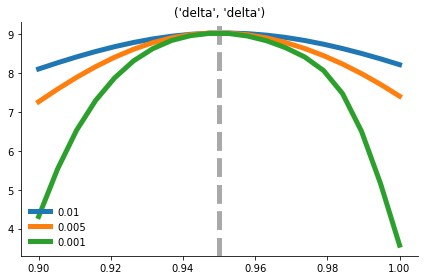

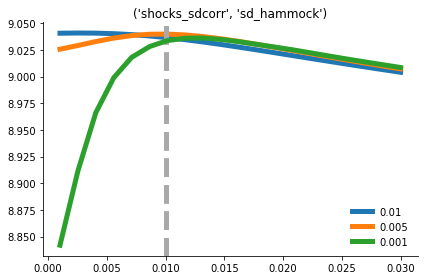

In [33]:
for index in [("delta", "delta"), ("shocks_sdcorr", "sd_hammock")]:
    fig, ax = plt.subplots()

    for tau in [0.01, 0.005, 0.001]:

        options = options_base.copy()
        options["estimation_tau"] = tau

        crit_func = rp.get_crit_func(params_base, options, df)

        upper, lower = params_base.loc[index][["upper", "lower"]]

        grid = np.linspace(lower, upper, 20)

        fvals = list()
        for value in grid:
            params = params_base.copy()
            params.loc[index, "value"] = value
            fvals.append(crit_func(params))

        ax.axvline(params_base.loc[index, "value"], color="#A9A9A9", linestyle="--")

        ax.plot(grid, fvals, label=f"{tau}")
        ax.set_title(index)
        ax.legend()

    plt.show()